In [9]:
import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.datasets import CIFAR100
import pandas as pd
from torchvision.transforms import v2
from torch.backends import cudnn
from torch import GradScaler
from torch import optim
from tqdm import tqdm
from torchvision import tv_tensors
import random
import torchvision.transforms as transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [10]:
device = torch.device('cuda')
print(torch.cuda.is_available())
cudnn.benchmark = True
pin_memory = True
enable_half = True  # Disable for CPU, it is slower!
scaler = GradScaler(device, enabled=enable_half)

True


In [11]:
class SimpleCachedDataset(Dataset):
    def __init__(self, dataset):
        # Runtime transforms are not implemented in this simple cached dataset.
        self.data = tuple([x for x in dataset])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]


In [12]:
basic_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25), inplace=True)
])

other_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
])

aug_policy_one = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(90, 270)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
])

aug_policy_two = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(p=1.0), 
    transforms.RandomHorizontalFlip(p=1.0),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
])

# aug_policy_three = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.RandomPerspective(distortion_scale=0.5, p=1.0),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
# ])

# aug_policy_four = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
# ])

# aug_policy_five = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.RandomResizedCrop(size=(32, 32), scale=(0.6, 0.8)),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
# ])

aug_policy_six = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
])

aug_policy_seven = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomErasing(p=1.0, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
])

aug_policy_eight = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(p=1.0),
    transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
])

base_train_set = torchvision.datasets.CIFAR100(
    root='/kaggle/input/fii-atnn-2024-assignment-2',
    train=True,   
    download=True,
    transform=None
)

test_set = torchvision.datasets.CIFAR100(
    root='/kaggle/input/fii-atnn-2024-assignment-2',
    train=False, 
    download=True,
    transform=basic_transforms
)

images = base_train_set.data  # This is a numpy array of the images
pil_images = [Image.fromarray(image) for image in images]
labels = base_train_set.targets  # The labels are already stored in a list

train_set = [(other_transforms(img), label) for img, label in zip(images, labels)]

train_set_aug_one = [(aug_policy_one(img), label) for img, label in zip(images, labels)]
train_set_aug_two = [(aug_policy_two(img), label) for img, label in zip(images, labels)]
# train_set_aug_three = [(aug_policy_three(img), label) for img, label in zip(images, labels)]
# train_set_aug_four = [(aug_policy_four(img), label) for img, label in zip(images, labels)]
# train_set_aug_five = [(aug_policy_five(img), label) for img, label in zip(images, labels)]
train_set_aug_six = [(aug_policy_six(img), label) for img, label in zip(images, labels)]
train_set_aug_seven = [(aug_policy_seven(img), label) for img, label in zip(images, labels)]
train_set_aug_eight = [(aug_policy_eight(img), label) for img, label in zip(images, labels)]

train_set_aug_one = SimpleCachedDataset(train_set_aug_one)
train_set_aug_two = SimpleCachedDataset(train_set_aug_two)
# train_set_aug_three = SimpleCachedDataset(train_set_aug_three)
# train_set_aug_four = SimpleCachedDataset(train_set_aug_four)
# train_set_aug_five = SimpleCachedDataset(train_set_aug_five)
train_set_aug_six = SimpleCachedDataset(train_set_aug_six)
train_set_aug_seven = SimpleCachedDataset(train_set_aug_seven)
train_set_aug_eight = SimpleCachedDataset(train_set_aug_eight)
train_set = SimpleCachedDataset(train_set)
test_set = SimpleCachedDataset(test_set)

train_set = ConcatDataset([train_set, train_set_aug_one, train_set_aug_two, train_set_aug_six, train_set_aug_seven, train_set_aug_eight])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=pin_memory)
test_loader = DataLoader(test_set, batch_size=500, pin_memory=pin_memory)


Files already downloaded and verified
Files already downloaded and verified


Trainset size: 300000


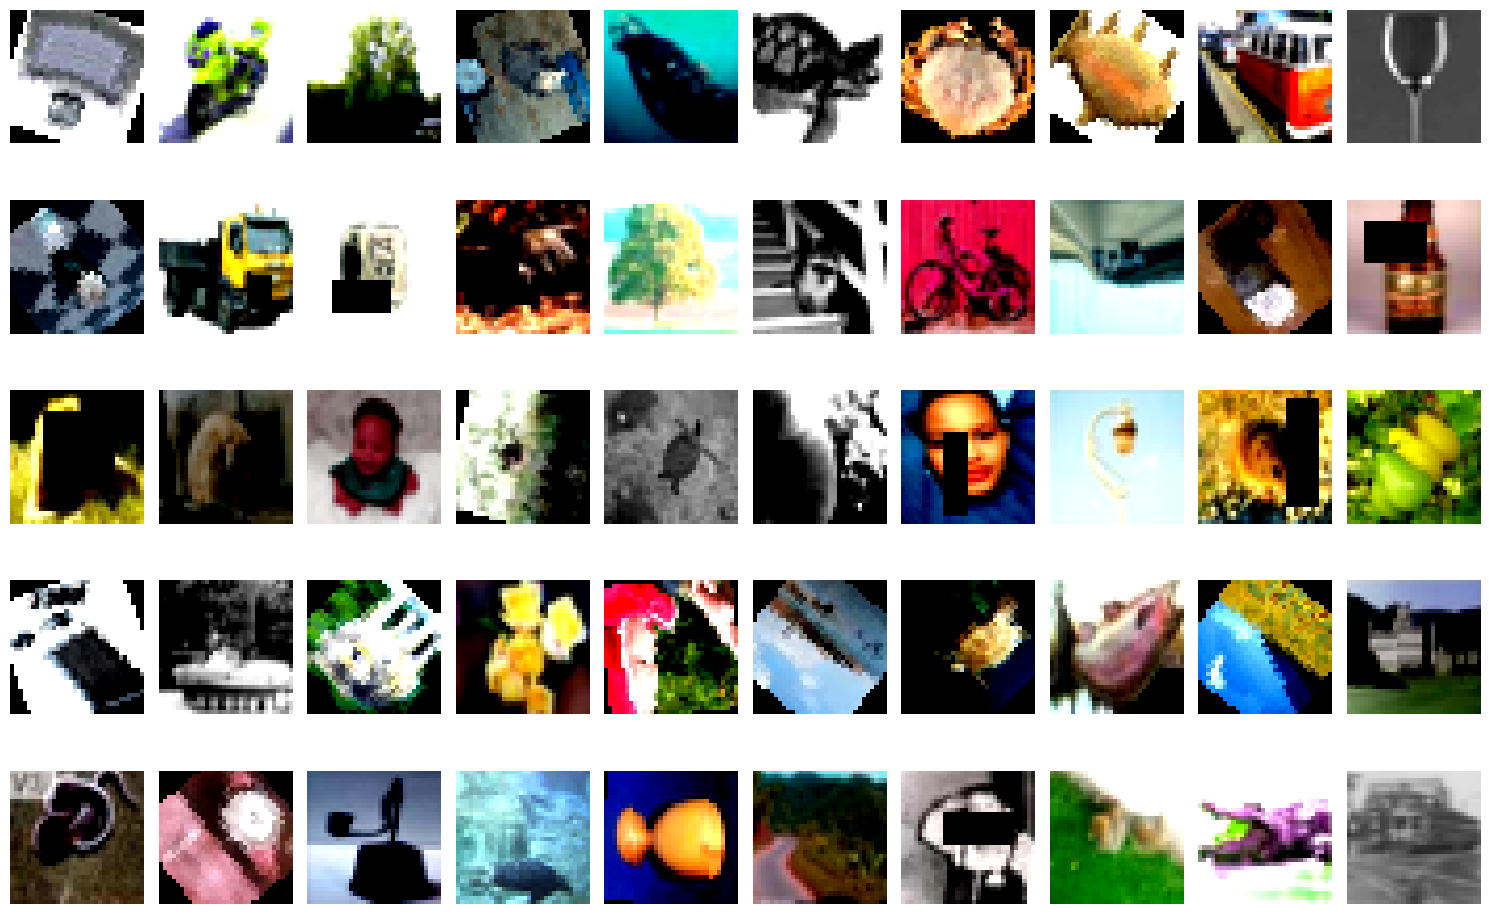

In [13]:
print(f'Trainset size: {len(train_set)}')

num_images = 50

fig, axes = plt.subplots(5, 10, figsize=(15, 10))

for i in range(num_images):
    random_idx = random.randint(0, len(train_loader.dataset) - 1)
    img, _ = train_loader.dataset[random_idx]
    
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    
    img = np.clip((img * 0.5) + 0.5, 0, 1)
    
    row = i // 10
    col = i % 10
    
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [14]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()

        self.layers = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Classifier
            nn.Flatten(),
            nn.Linear(512, 100)
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.layers(x)


In [15]:
model = VGG16().to(device)
model = torch.jit.script(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, fused=True)

In [16]:
def train():
    model.train()
    correct = 0
    total = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        with torch.autocast(device.type, enabled=enable_half):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        predicted = outputs.argmax(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    return 100.0 * correct / total

In [17]:
@torch.inference_mode()
def val():
    model.eval()
    correct = 0
    total = 0

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        with torch.autocast(device.type, enabled=enable_half):
            outputs = model(inputs)

        predicted = outputs.argmax(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    return 100.0 * correct / total

In [18]:
@torch.inference_mode()
def inference():
    model.eval()
    
    labels = []
    
    for inputs, _ in test_loader:
        inputs = inputs.to(device, non_blocking=True)
        with torch.autocast(device.type, enabled=enable_half):
            outputs = model(inputs)

        predicted = outputs.argmax(1).tolist()
        labels.extend(predicted)
    
    return labels

In [19]:
best = 0.0
epochs = list(range(50))
with tqdm(epochs) as tbar:
    for epoch in tbar:
        train_acc = train()
        val_acc = val()
        if val_acc > best:
            best = val_acc
        tbar.set_description(f"Train: {train_acc:.2f}, Val: {val_acc:.2f}, Best: {best:.2f}")

Train: 99.90, Val: 60.36, Best: 60.63: 100%|██████████| 50/50 [1:04:42<00:00, 77.66s/it]


In [20]:
data = {
    "ID": [],
    "target": []
}


for i, label in enumerate(inference()):
    data["ID"].append(i)
    data["target"].append(label)

df = pd.DataFrame(data)
df.to_csv("/kaggle/working/submission.csv", index=False)